In [3]:
# Core imports
import pandas as pd
from typing import Literal, TypedDict, Annotated, Any
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_react_agent, tool
from langgraph.graph import StateGraph, END, START
# from langgraph.prebuilt.tool_executor import ToolExecutor
# from langgraph.prebuilt import add_messages
from langgraph.graph.message import add_messages
from datetime import datetime

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")


# Your LLM - plug in OpenAI or any ChatModel
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4", temperature=0)


In [4]:
llm.invoke("what is supervisor multi agent")

AIMessage(content='Supervisor multi-agent is a system in which multiple agents, or software programs, are overseen by a supervisory agent. This supervisor agent is responsible for coordinating the actions of the other agents, ensuring they work together effectively to achieve a common goal. This type of system is often used in artificial intelligence and machine learning applications, where multiple agents may be working on different aspects of a problem or task.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 12, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-Bj88OS0e6gyWOlDD9SYSP0udL3gQX', 'finish_reason': 'stop', 'logprobs': None}, id='run--0554b006-26f0-4ceb-b17d-e0220

In [58]:
class DateModel(TypedDict):
    date: str

class DateTimeModel(TypedDict):
    date: str  # "03-09-2024 08:30"

class IdentificationNumberModel(TypedDict):
    id: int


In [35]:
# import re
# from pydantic import BaseModel, Field, field_validator


# class DateTimeModel(BaseModel):
#     date: str = Field(
#         description="Properly formatted datetime",
#         pattern=r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$'
#     )

#     @field_validator("date")
#     def check_format_date(cls, v: str) -> str:
#         if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$', v):
#             raise ValueError("The date must be in the format 'DD-MM-YYYY HH:MM'")
#         return v


# class DateModel(BaseModel):
#     date: str = Field(
#         description="Properly formatted date",
#         pattern=r'^\d{2}-\d{2}-\d{4}$'
#     )

#     @field_validator("date")
#     def check_format_date(cls, v: str) -> str:
#         if not re.match(r'^\d{2}-\d{2}-\d{4}$', v):
#             raise ValueError("The date must be in the format 'DD-MM-YYYY'")
#         return v


# class IdentificationNumberModel(BaseModel):
#     id: int = Field(description="Identification number (7 or 8 digits)")

#     @field_validator("id")
#     def check_format_id(cls, v: int) -> int:
#         if not re.match(r'^\d{7,8}$', str(v)):
#             raise ValueError("The ID must be a 7 or 8-digit number.")
#         return v


In [59]:
@tool
def check_availability_by_doctor(
    desired_date: DateModel,
    doctor_name: Literal[
        'kevin anderson', 'robert martinez', 'susan davis',
        'daniel miller', 'sarah wilson', 'michael green',
        'lisa brown', 'jane smith', 'emily johnson', 'john doe'
    ]
):
    """
    Check availability for a specific doctor on a given date.
    """
    df = pd.read_csv("availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda x: x.split(' ')[-1])
    rows = df[(df['date_slot'].str.startswith(desired_date["date"])) &
              (df['doctor_name'].str.lower() == doctor_name.lower()) &
              (df['is_available'])].groupby("doctor_name")["date_slot_time"].apply(list).reset_index()

    if rows.empty:
        return "No availability found."
    else:
        return f"Available for {doctor_name} on {desired_date["date"]}:\n" + ', '.join(rows.iloc[0]['date_slot_time'])

In [60]:
print(
    check_availability_by_doctor.invoke({
        "desired_date": DateModel(date="03-09-2024"),
        "doctor_name": "kevin anderson"
    })
)

Available for kevin anderson on 03-09-2024:
12:30, 14:00, 14:30, 15:00, 16:00, 16:30


In [61]:
@tool
def check_availability_by_specialization(desired_date: DateModel,
    specialization: Literal[
        "general_dentist", "cosmetic_dentist", "prosthodontist",
        "pediatric_dentist", "emergency_dentist", "oral_surgeon", "orthodontist"
    ]
) -> str:
    """
    Check availability for a specific specialization on a given date.
    """
    df = pd.read_csv("availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda x: x.split(' ')[-1])
    rows = df[(df['date_slot'].str.startswith(desired_date["date"])) &
              (df['specialization'] == specialization) &
              (df['is_available'])].groupby(["specialization", "doctor_name"])["date_slot_time"].apply(list).reset_index()

    if rows.empty:
        return "No availability found."
    else:
        result = f"Available {specialization} slots:\n"
        for _, row in rows.iterrows():
            result += f"{row['doctor_name']}: {', '.join(row['date_slot_time'])}\n"
        return result

In [62]:
print(
    check_availability_by_specialization.invoke({
        "desired_date": DateModel(date="03-09-2024"),
        "specialization": "orthodontist"
    })
)

Available orthodontist slots:
kevin anderson: 12:30, 14:00, 14:30, 15:00, 16:00, 16:30



In [63]:
@tool
def set_appointment(
    desired_date: DateTimeModel, 
    id_number: IdentificationNumberModel, 
    doctor_name: Literal[
        'kevin anderson', 'robert martinez', 'susan davis', 'daniel miller',
        'sarah wilson', 'michael green', 'lisa brown', 'jane smith',
        'emily johnson', 'john doe'
    ]
    ) -> str:
    """
    Set an appointment slot with the doctor if available.
    """
    
    df = pd.read_csv("availability.csv")
    
    match = (df["date_slot"] == desired_date["date"]) & \
            (df["doctor_name"] == doctor_name) & \
            (df["is_available"] == True)

    if df[match].empty:
        return "❌ No available appointment at that time."
    
    df.loc[match, ["is_available", "patient_to_attend"]] = [False, id_number["id"]]
    df.to_csv("availability.csv", index=False)
    
    return f"✅ Appointment booked for {desired_date["date"]} with {doctor_name}"


In [81]:

print(
    set_appointment.invoke({
        "desired_date": DateTimeModel(date="03-09-2024 15:30"),
        "id_number": IdentificationNumberModel(id=1111223),
        "doctor_name": "kevin anderson"
    })
)

✅ Appointment booked for 03-09-2024 15:30 with kevin anderson


In [76]:
df = pd.read_csv("availability.csv")
df.dtypes

date_slot             object
specialization        object
doctor_name           object
is_available            bool
patient_to_attend    float64
dtype: object

In [77]:
@tool
def cancel_appointment(
    date: DateTimeModel, 
    id_number: IdentificationNumberModel, 
    doctor_name: Literal[
        'kevin anderson', 'robert martinez', 'susan davis', 'daniel miller',
        'sarah wilson', 'michael green', 'lisa brown', 'jane smith',
        'emily johnson', 'john doe'
    ]
) -> str:
    """
    Cancel an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv("availability.csv")
    
    match = (df["date_slot"] == date["date"]) & \
            (df["doctor_name"] == doctor_name) & \
            (df["patient_to_attend"] == id_number["id"])

    if df[match].empty:
        return "⚠️ No such appointment found."
    
    df.loc[match, ["is_available", "patient_to_attend"]] = [True, None]
    df.to_csv("availability.csv", index=False)
    
    return "✅ Appointment successfully cancelled."


In [78]:
print(
    cancel_appointment.invoke({
    "date": DateTimeModel(date="03-09-2024 15:30"),
    "id_number": IdentificationNumberModel(id=1111223), 
    "doctor_name": "kevin anderson"
    })
)


✅ Appointment successfully cancelled.


In [82]:
@tool
def reschedule_appointment(
    old_date: DateTimeModel,
    new_date: DateTimeModel,
    id_number: IdentificationNumberModel,
    doctor_name: Literal[
        'kevin anderson', 'robert martinez', 'susan davis', 'daniel miller',
        'sarah wilson', 'michael green', 'lisa brown', 'jane smith',
        'emily johnson', 'john doe'
    ]
) -> str:
    """
    Reschedule an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv("availability.csv")

    # Check new availability
    new_match = (df["date_slot"] == new_date["date"]) & \
                (df["doctor_name"] == doctor_name) & \
                (df["is_available"] == True)

    if df[new_match].empty:
        return "❌ New date not available."

    # Cancel old
    cancel_appointment.invoke({
        "date": old_date,
        "id_number": id_number,
        "doctor_name": doctor_name
    })

    # Book new
    set_appointment.invoke({
        "desired_date": new_date,
        "id_number": id_number,
        "doctor_name": doctor_name
    })

    return f"✅ Rescheduled to {new_date["date"]}"


In [84]:
print(
    reschedule_appointment.invoke({
        "old_date": DateTimeModel(date="03-09-2024 15:00"),
        "new_date": DateTimeModel(date="03-09-2024 16:00"),
        "id_number": IdentificationNumberModel(id=1111223),
        "doctor_name": "kevin anderson"
        }
    )
)

✅ Rescheduled to 03-09-2024 16:00


In [157]:
from typing import TypedDict, Literal, Any
from typing_extensions import Annotated

# Define the routing dictionary, indicating the next node and the reasoning behind it
class Router(TypedDict):
    next: Literal["information_node", "booking_node", "FINISH"]
    reasoning: str

# Define the agent state, including messages and tracking info
class AgentState(TypedDict):
    messages: Annotated[list[Any], 'add_messages']  # You may want to define add_messages somewhere
    id_number: int
    next: str
    query: str
    current_reasoning: str

# Mapping of node names to their descriptions
members_dict = {
    'information_node': 'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
    'booking_node': 'specialized agent to only to book, cancel or reschedule appointment'
}

members_dict

{'information_node': 'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
 'booking_node': 'specialized agent to only to book, cancel or reschedule appointment'}

In [158]:
options = list(members_dict.keys()) + ["FINISH"]

options

['information_node', 'booking_node', 'FINISH']

In [159]:
worker_info = '\n\n'.join([f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished'

print(worker_info)

WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished


In [160]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between following workers. "
    "### SPECIALIZED ASSISTANT:\n"
    f"{worker_info}\n\n"
    "Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. "
    "If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, "
    "delegate the task to the appropriate specialized workers. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "UTILIZE last conversation to assess if the conversation should end you answered the query, then route to FINISH "
    )

print(system_prompt)


You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:
WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished

Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, delegate the task to the appropriate specialized workers. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.UTILIZE last conversation to assess if the conversation should end you answered 

In [161]:
# from langchain_core.runnables import Runnable
# from langchain_core.output_parsers.string import StrOutputParser

# def supervisor_node(state: AgentState) -> Router:
#     last_message = state["messages"][-1].content

#     prompt = ChatPromptTemplate.from_messages([
#         ("system", system_prompt),
#         ("human", f"User Query: {state['query']}\nConversation: {last_message}\nWhich worker should handle this next?")
#     ])

#     chain = prompt | llm | StrOutputParser()

#     response = chain.invoke({"query": state["query"]})
    
#     # Simple heuristic: route based on keywords
#     if "book" in state["query"] or "cancel" in state["query"] or "reschedule" in state["query"]:
#         next_node = "booking_node"
#     elif "availability" in state["query"] or "open slot" in state["query"]:
#         next_node = "information_node"
#     else:
#         next_node = "FINISH"

#     return {
#         "next": next_node,
#         "reasoning": response
#     }


In [162]:
from langgraph.types import Command


In [163]:
def supervisor_node(state:AgentState) -> Command[Literal['information_node', 'booking_node', '__end__']]:
    print("**************************below is my state right after entering****************************")
    print(state)
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + state["messages"]
    
    print("***********************this is my message*****************************************")
    print(messages)
    
    # query = state['messages'][-1].content if state["messages"] else ""
    query = ''
    if len(state['messages']) == 1:
        query = state['messages'][0].content
      
    print("************below is my query********************")    
    print(query)
    
    response = llm.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("********************************this is my goto*************************")
    print(goto)
    
    print("********************************")
    print(response["reasoning"])
          
    if goto == "FINISH":
        goto = END
        
    print("**************************below is my state****************************")
    print(state)
    
    if query:
        return Command(goto=goto, update={'next': goto, 
                                          'query': query, 
                                          'current_reasoning': response["reasoning"],
                                          'messages': [HumanMessage(content=f"user's identification number is {state['id_number']}")]
                        })
    return Command(goto=goto, update={'next': goto, 
                                      'current_reasoning': response["reasoning"]}
                   )

In [164]:
# from langchain.agents import create_react_agent
# from langchain_core.prompts import ChatPromptTemplate
# from langgraph.types import Command


# def information_node(state: AgentState) -> Command[Literal["supervisor"]]:
#     print("📘 Called Information Node")

#     prompt = ChatPromptTemplate.from_messages([
#         ("system", "You are a specialized assistant for FAQs and doctor availability. Use tools. Always assume the current year is 2024."),
#         ("placeholder", "{messages}")
#     ])

#     # agent = create_react_agent(
#     #     model=llm,
#     #     tools=[check_availability_by_doctor, check_availability_by_specialization],
#     #     prompt=prompt
#     # )
#     agent = create_react_agent(model=llm,tools=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    

#     result = agent.invoke(state)

#     return Command(update={
#         "messages": state["messages"] + [
#             AIMessage(content=result["messages"][-1].content, name="information_node")
#         ]
#     }, goto="supervisor")

In [165]:
def information_node(state:AgentState) -> Command[Literal['supervisor']]:
    print("*****************called information node************")
    
    system_prompt = "You are specialized agent to provide information related to availability of doctors or any FAQs related to hospital based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    
    information_agent = create_react_agent(llm=llm,tools_name=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    
    result = information_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="information_node")
                #HumanMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor",
    )

In [166]:
# def booking_node(state: AgentState) -> Command[Literal["supervisor"]]:
#     print("📗 Called Booking Node")

#     prompt = ChatPromptTemplate.from_messages([
#         ("system", "You are a specialized assistant for setting, cancelling, and rescheduling appointments. Use tools. Always assume the current year is 2024."),
#         ("placeholder", "{messages}")
#     ])

#     # agent = create_react_agent(
#     #     model=llm,
#     #     tools=[set_appointment, cancel_appointment, reschedule_appointment],
#     #     prompt=prompt
#     # )
    
#     agent = create_react_agent(model=llm,tools=[set_appointment,cancel_appointment,reschedule_appointment],prompt=system_prompt)
    

#     result = agent.invoke(state)

#     return Command(update={
#         "messages": state["messages"] + [
#             AIMessage(content=result["messages"][-1].content, name="booking_node")
#         ]
#     }, goto="supervisor")


In [172]:
from langchain.agents.react.base import AGENT_PROMPT
print(AGENT_PROMPT)

ImportError: cannot import name 'AGENT_PROMPT' from 'langchain.agents.react.base' (c:\Users\44787\anaconda3\envs\agent\Lib\site-packages\langchain\agents\react\base.py)

In [ ]:
def booking_node(state:AgentState) ->  Command[Literal['supervisor']]:
    
    print("*****************called booking node************")
    
    prompt = "You are specialized agent to set, cancel or reschedule appointment based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    booking_agent = create_react_agent(llm=llm,tools=[set_appointment,cancel_appointment,reschedule_appointment],prompt=system_prompt)

    result = booking_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
                #HumanMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor",
    )

In [186]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_tool_calling_agent
# from langgraph.prebuilt import ToolExecutor
from langchain_core.messages import AIMessage
from langchain_core.runnables import Runnable
from typing import Literal
# from langgraph.graph import Command

def booking_node(state: AgentState) -> Command[Literal['supervisor']]:
    print("*****************called booking node************")

    tools = [set_appointment, cancel_appointment, reschedule_appointment]

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a helpful assistant that helps users set, cancel, or reschedule doctor appointments. "
            "Use the tools available. If any detail is missing, ask the user for it. Assume the current year is 2024."
        ),
        ("placeholder", "{messages}"),
        ("system", "{agent_scratchpad}")
    ])

    # Create agent
    booking_agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)

    result = booking_agent.invoke(state)

    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor"
    )


In [187]:
from typing_extensions import Annotated
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    messages: Annotated[list[Any], add_messages]
    id_number: int
    next: str
    query: str
    current_reasoning: str


In [188]:
graph = StateGraph(AgentState)
graph.add_node("supervisor", supervisor_node)
graph.add_node("information_node", information_node)
graph.add_node("booking_node", booking_node)
graph.add_edge(START, "supervisor")

app = graph.compile()

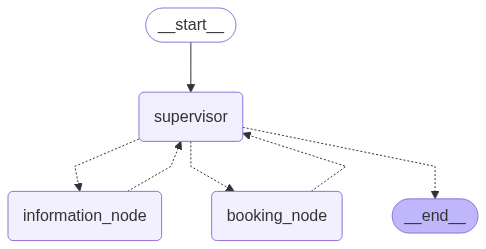

In [189]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [190]:
inputs = [HumanMessage(content="I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024")]

initial_state = {
    "messages": inputs,
    "id_number": 10232303,
    "next": "supervisor",
    "query": inputs[-1].content,
    "current_reasoning": ""
}

result = app.invoke(initial_state)


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024', additional_kwargs={}, response_metadata={}, id='24c945a8-340a-4657-bba1-8e4867f4eeeb')], 'id_number': 10232303, 'next': 'supervisor', 'query': 'I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024', 'current_reasoning': ''}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \nDESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.\n\nWORKER: booking_node \nDESCRIPTION: specialized agent to only to book, cancel or reschedule appointment\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to F

c:\Users\44787\anaconda3\envs\agent\Lib\site-packages\langchain_openai\chat_models\base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


********************************this is my goto*************************
booking_node
********************************
The user wants to book an appointment which is a task for the booking_node.
**************************below is my state****************************
{'messages': [HumanMessage(content='I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024', additional_kwargs={}, response_metadata={}, id='24c945a8-340a-4657-bba1-8e4867f4eeeb')], 'id_number': 10232303, 'next': 'supervisor', 'query': 'I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024', 'current_reasoning': ''}
*****************called booking node************


KeyError: 'intermediate_steps'

In [101]:
result

{'messages': [HumanMessage(content='I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024', additional_kwargs={}, response_metadata={}, id='8c33c894-7c3b-4b5d-be47-f5b7c5566490')],
 'id_number': 10232303,
 'next': 'booking_node',
 'query': 'I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024',
 'current_reasoning': ''}

In [102]:
# Add a new human message
new_input = HumanMessage(content="Yes, please book it.")

# Append to existing state and re-invoke
new_state = {
    **result,
    "messages": result["messages"] + [new_input],
    "query": new_input.content,
    "next": "supervisor"
}

new_result = app.invoke(new_state)


In [103]:
new_result

{'messages': [HumanMessage(content='I want to book an appointment with Dr. John Doe at 08:30 on 03-09-2024', additional_kwargs={}, response_metadata={}, id='8c33c894-7c3b-4b5d-be47-f5b7c5566490'),
  HumanMessage(content='Yes, please book it.', additional_kwargs={}, response_metadata={}, id='17b87541-a0a9-417e-b6ed-34b03d926353')],
 'id_number': 10232303,
 'next': 'booking_node',
 'query': 'Yes, please book it.',
 'current_reasoning': ''}